In [ ]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from fractal_functions import *

# Other


In [ ]:
def bootstrap_resistance_statistic(num_samples: int, level: int, stat):
    """
    Calculates a 95% confidence interval for a given statistic of the effective
    resistance R(tail_1, tail_2) using bootstrapping.

    This is a NetworkX/SciPy translation of the original SageMath function.

    Args:
        num_samples (int): The number of random resistance values to generate
                           for each graph level n (bootstrap sample size).
        highest_graph_level (int): The maximum n to analyze.
        statistic_func (callable): The statistic to compute (e.g., np.mean, np.var).

    Returns:
        tuple: A tuple of three NumPy arrays:
               (mid_points, lower_bounds, upper_bounds) for the confidence
               intervals at each level n.
    """
    # Create lists to store the results for each level n
    mid_points = []
    lower_bounds = []
    upper_bounds = []

    # --- Use the NetworkX naming convention for the tail vertices ---
    v_a = 'tail_1'
    v_b = 'tail_2'

    print("--- Starting Bootstrap Analysis ---")
    # Iterate through graph levels, starting from n=2
    for n in range(2, level + 1):
        print(f"Analyzing graph level n={n}...")
        
        # --- Use the NetworkX graph creation function ---
        # Create the graph topology once per level n for efficiency.
        G = hanoi_t(n)
        
        # This list will hold the resistance values from each random weighting
        res_list = []
        
        # --- Resistance Simulation Loop ---
        # Calculate `num_samples` resistance values for this n
        for _ in range(num_samples):
        
            # --- Use the dedicated NetworkX weighting function ---
            # This function modifies the graph G in-place with new random weights.
            add_random_weights(G, n)

            # --- Use the dedicated NetworkX single resistance function ---
            # Compute the resistance for this specific random instance
            R_ab = compute_single_resistance1(G, v_a, v_b)
            res_list.append(R_ab)

        # Convert the list of results to a NumPy array for bootstrapping
        res_arr = np.array(res_list)

        # --- Use bootstrapping to compute the confidence interval ---
        # This part is pure SciPy and remains unchanged.
        # The `random_state` ensures the bootstrap resampling is reproducible.
        boot = bootstrap((res_arr,), statistic=stat, confidence_level=0.95, random_state=42)
        ci = boot.confidence_interval

        # Store the results from the confidence interval
        lower_bounds.append(ci.low)
        upper_bounds.append(ci.high)
        # We can use the bootstrap's standard error to define the midpoint,
        # but the CI midpoint is also a reasonable choice.
        mid_points.append(boot.bootstrap_distribution.mean())
        
        print(f"  -> 95% CI for {stat.__name__}(R) at n={n}: ({ci.low:.8f}, {ci.high:.8f})")

    print("--- Bootstrap Analysis Complete ---")
    return np.array(mid_points), np.array(lower_bounds), np.array(upper_bounds)

In [ ]:
n=10; N = 100
mid_mean, l_mean, u_mean = bootstrap_resistance_statistic(num_samples = N, level = n, stat=np.mean)

--- Starting Bootstrap Analysis ---
Analyzing graph level n=2...
  -> 95% CI for mean(R) at n=2: (0.88969581, 1.03465560)
Analyzing graph level n=3...
  -> 95% CI for mean(R) at n=3: (0.82179221, 0.92424022)
Analyzing graph level n=4...
  -> 95% CI for mean(R) at n=4: (0.86550904, 0.93454817)
Analyzing graph level n=5...
  -> 95% CI for mean(R) at n=5: (0.83770866, 0.88341022)
Analyzing graph level n=6...
  -> 95% CI for mean(R) at n=6: (0.88155221, 0.90831510)
Analyzing graph level n=7...
  -> 95% CI for mean(R) at n=7: (0.90484889, 0.91879432)
Analyzing graph level n=8...
  -> 95% CI for mean(R) at n=8: (0.92192111, 0.93139010)
Analyzing graph level n=9...
  -> 95% CI for mean(R) at n=9: (0.94282548, 0.94896858)
Analyzing graph level n=10...
  -> 95% CI for mean(R) at n=10: (0.95720405, 0.96087104)
--- Bootstrap Analysis Complete ---


In [ ]:
n=11
mid_var, l_var, u_var = bootstrap_resistance_statistic(num_samples = 20, level = n, stat=np.var)

--- Starting Bootstrap Analysis ---
Analyzing graph level n=2...
  -> 95% CI for var(R) at n=2: (0.04780161, 0.14606851)
Analyzing graph level n=3...
  -> 95% CI for var(R) at n=3: (0.01896993, 0.05676760)
Analyzing graph level n=4...
  -> 95% CI for var(R) at n=4: (0.01349674, 0.03334318)
Analyzing graph level n=5...
  -> 95% CI for var(R) at n=5: (0.00327466, 0.00818538)
Analyzing graph level n=6...
  -> 95% CI for var(R) at n=6: (0.00276885, 0.00914773)
Analyzing graph level n=7...
  -> 95% CI for var(R) at n=7: (0.00159141, 0.00420812)
Analyzing graph level n=8...
  -> 95% CI for var(R) at n=8: (0.00034094, 0.00090608)
Analyzing graph level n=9...
  -> 95% CI for var(R) at n=9: (0.00022329, 0.00056793)
Analyzing graph level n=10...
  -> 95% CI for var(R) at n=10: (0.00002470, 0.00009241)
Analyzing graph level n=11...
  -> 95% CI for var(R) at n=11: (0.00001315, 0.00004150)
--- Bootstrap Analysis Complete ---


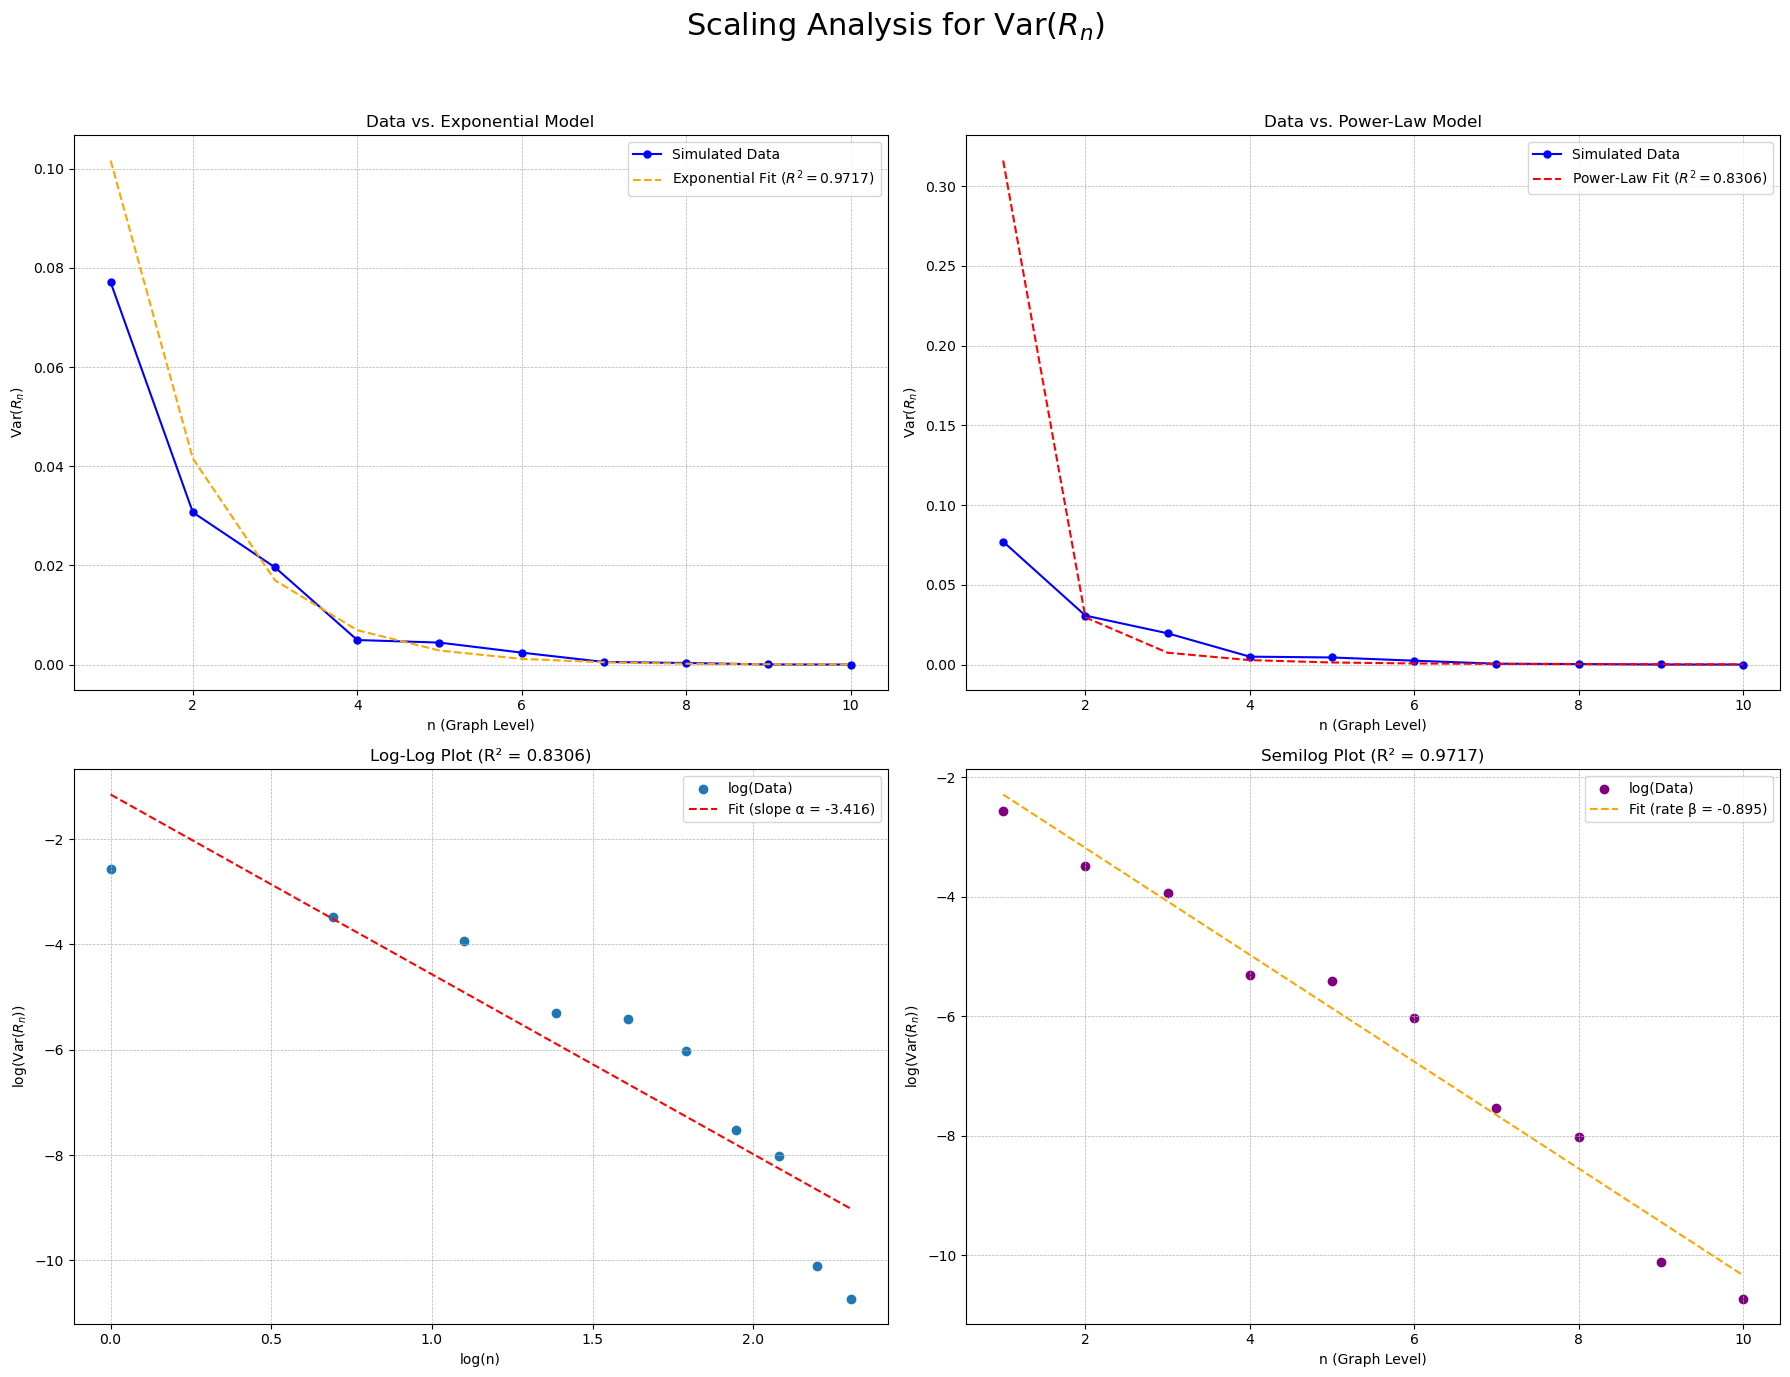

In [ ]:
n_values = np.arange(1, n)
# filter out the first few?
n_filt = n_values
var_filt = mid_var

analyze_statistic_scaling(n_filt, var_filt, statistic_name=r"$\operatorname{Var}(R_n)$")
# analyze_statistic_scaling(n_values, mid_var, statistic_name=r"$\operatorname{Var}(R_n)$")

In [ ]:
from scipy.stats import linregress

# --- Helper functions to generate the fit curves ---

def generate_power_law_fit(x_values, slope, intercept):
    """
    Translates a linear fit from a log-log plot back into a power-law curve.
    Model: y = C * x^alpha
    """
    # From log(y) = alpha*log(x) + log(C), we have:
    # alpha = slope
    # C = e^intercept
    C = np.exp(intercept)
    alpha = slope
    return C * (x_values**alpha)

def generate_exponential_fit(x_values, slope, intercept):
    """
    Translates a linear fit from a semilog plot back into an exponential curve.
    Model: y = C * e^(beta*x)
    """
    # From log(y) = beta*x + log(C), we have:
    # beta = slope
    # C = e^intercept
    C = np.exp(intercept)
    beta = slope
    return C * np.exp(beta * x_values)

# --- The Main Analysis and Plotting Function ---
def analyze_statistic_scaling(n_values, statistic_values, statistic_name="Statistic"):
    """
    Creates a comprehensive 2x2 dashboard to analyze the scaling behavior
    of a single statistic (e.g., mean or variance).

    It compares power-law vs. exponential fits both visually on a linear
    scale and quantitatively via log-log and semilog plots.
    """
    # --- Data Preparation & Safety Check ---
    # Filter out any non-positive values to prevent errors with log()
    valid_indices = statistic_values > 1e-12 # Use a small epsilon for stability
    n_filt = n_values[valid_indices]
    stat_filt = statistic_values[valid_indices]
    
    # --- Perform the Regressions ---
    # Log-Log data for Power-Law fit: log(y) vs log(x)
    log_n = np.log(n_filt)
    log_stat = np.log(stat_filt)
    slope_alpha, icept_alpha, r_alpha, _, _ = linregress(log_n, log_stat)
    
    # Semilog data for Exponential fit: log(y) vs x
    slope_beta, icept_beta, r_beta, _, _ = linregress(n_filt, log_stat)

    # --- Generate the fit curves for the linear plots ---
    power_law_fit = generate_power_law_fit(n_filt, slope_alpha, icept_alpha)
    exponential_fit = generate_exponential_fit(n_filt, slope_beta, icept_beta)

    # --- Create the 2x2 Plotting Dashboard ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'Scaling Analysis for {statistic_name}', fontsize=22)
    ax = axes.ravel()

    # --- Plot 1: Linear Scale with Exponential Fit ---
    ax[0].plot(n_filt, stat_filt, label='Simulated Data', color='b', marker='o', ms=5)
    ax[0].plot(n_filt, exponential_fit, label=f'Exponential Fit ($R^2={r_beta**2:.4f}$)', color='orange', linestyle='--')
    ax[0].set_xlabel('n (Graph Level)')
    ax[0].set_ylabel(statistic_name)
    ax[0].set_title('Data vs. Exponential Model')
    ax[0].legend()
    ax[0].grid(True, linestyle='--', linewidth=0.5)

    # --- Plot 2: Linear Scale with Power-Law Fit ---
    ax[1].plot(n_filt, stat_filt, label='Simulated Data', color='b', marker='o', ms=5)
    ax[1].plot(n_filt, power_law_fit, label=f'Power-Law Fit ($R^2={r_alpha**2:.4f}$)', color='r', linestyle='--')
    ax[1].set_xlabel('n (Graph Level)')
    ax[1].set_ylabel(statistic_name)
    ax[1].set_title('Data vs. Power-Law Model')
    ax[1].legend()
    ax[1].grid(True, linestyle='--', linewidth=0.5)

    # --- Plot 3: Log-Log Diagnostic Plot ---
    ax[2].scatter(log_n, log_stat, label='log(Data)')
    fit_line_alpha = slope_alpha * log_n + icept_alpha
    ax[2].plot(log_n, fit_line_alpha, color='r', linestyle='--',
               label=f'Fit (slope α = {slope_alpha:.3f})')
    ax[2].set_xlabel('log(n)')
    ax[2].set_ylabel(f'log({statistic_name})')
    ax[2].set_title(f'Log-Log Plot (R² = {r_alpha**2:.4f})')
    ax[2].legend()
    ax[2].grid(True, linestyle='--', linewidth=0.5)
    
    # --- Plot 4: Semilog Diagnostic Plot ---
    ax[3].scatter(n_filt, log_stat, label='log(Data)', color='purple')
    fit_line_beta = slope_beta * n_filt + icept_beta
    ax[3].plot(n_filt, fit_line_beta, color='orange', linestyle='--',
               label=f'Fit (rate β = {slope_beta:.3f})')
    ax[3].set_xlabel('n (Graph Level)')
    ax[3].set_ylabel(f'log({statistic_name})')
    ax[3].set_title(f'Semilog Plot (R² = {r_beta**2:.4f})')
    ax[3].legend()
    ax[3].grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
# --- Helper function remains the same ---
def generate_exponential_fit(x_values, slope, intercept):
    """
    Translates a linear fit from a semilog plot back into an exponential curve.
    Model: y = C * e^(beta*x)
    """
    C = np.exp(intercept)
    beta = slope
    return C * np.exp(beta * x_values)

# --- New, Focused Plotting Function for the 1x2 Presentation Figure ---

def plot_exponential_analysis_pair(n_values, statistic_values, statistic_name, filename):
    """
    Creates a 1x2 figure for presentation, showing both the exponential fit on a
    linear scale and the linear relationship on a semilog scale.

    Args:
        n_values (array-like): The independent variable (e.g., graph level n).
        statistic_values (array-like): The dependent variable (e.g., Var(R)).
        statistic_name (str): The name of the statistic for axis labeling (e.g., "Var(R)").
        filename (str): The path to save the output image (e.g., "variance_decay_pair.png").
    """
    # --- 1. Data Preparation & Safety Check ---
    n_values = np.asarray(n_values)
    statistic_values = np.asarray(statistic_values)
    valid_indices = statistic_values > 1e-12
    n_filt = n_values[valid_indices]
    stat_filt = statistic_values[valid_indices]

    if len(n_filt) < 2:
        print(f"Warning: Not enough valid data points for {statistic_name}.")
        return

    # --- 2. Perform the Exponential Fit ---
    log_stat = np.log(stat_filt)
    slope_beta, intercept_beta, r_beta, _, _ = linregress(n_filt, log_stat)

    # --- 3. Generate Fit Curves ---
    # Curve for the linear plot
    exponential_fit = generate_exponential_fit(n_filt, slope_beta, intercept_beta)
    # Line for the semilog plot
    fit_line_beta = slope_beta * n_filt + intercept_beta

    # --- 4. Create the 1x2 Plot Figure ---
    # We use (1, 2) to get two plots side-by-side. Adjust figsize for good aspect ratio.
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Scaling Analysis for {statistic_name}', fontsize=22)

    # --- Plot 1 (Left): Data vs. Exponential Model ---
    ax0 = axes[0]
    ax0.plot(n_filt, stat_filt, label='Simulated Data', color='b', marker='o', ms=5)
    ax0.plot(n_filt, exponential_fit, label=f'Exponential Fit ($R^2={r_beta**2:.4f}$)', color='orange', linestyle='--')
    ax0.set_xlabel('n (Graph Level)', fontsize=12)
    ax0.set_ylabel(statistic_name, fontsize=12)
    ax0.set_title('Data vs. Exponential Model', fontsize=14)
    ax0.legend()
    ax0.grid(True, linestyle='--', linewidth=0.5)

    # --- Plot 2 (Right): Semilog Diagnostic Plot ---
    ax1 = axes[1]
    ax1.scatter(n_filt, log_stat, label='log(Data)', color='purple')
    ax1.plot(n_filt, fit_line_beta, color='orange', linestyle='--',
               label=f'Fit (rate β = {slope_beta:.3f})')
    ax1.set_xlabel('n (Graph Level)', fontsize=12)
    ax1.set_ylabel(f'log({statistic_name})', fontsize=12)
    ax1.set_title(f'Semilog Plot (R² = {r_beta**2:.4f})', fontsize=14)
    ax1.legend()
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # --- 5. Final Formatting and Saving ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent suptitle overlap
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

    print(f"Plot saved to {filename}")
    print(f"Fit parameters for {statistic_name}: Decay Rate (β) = {slope_beta:.4f}, R² = {r_beta**2:.4f}")

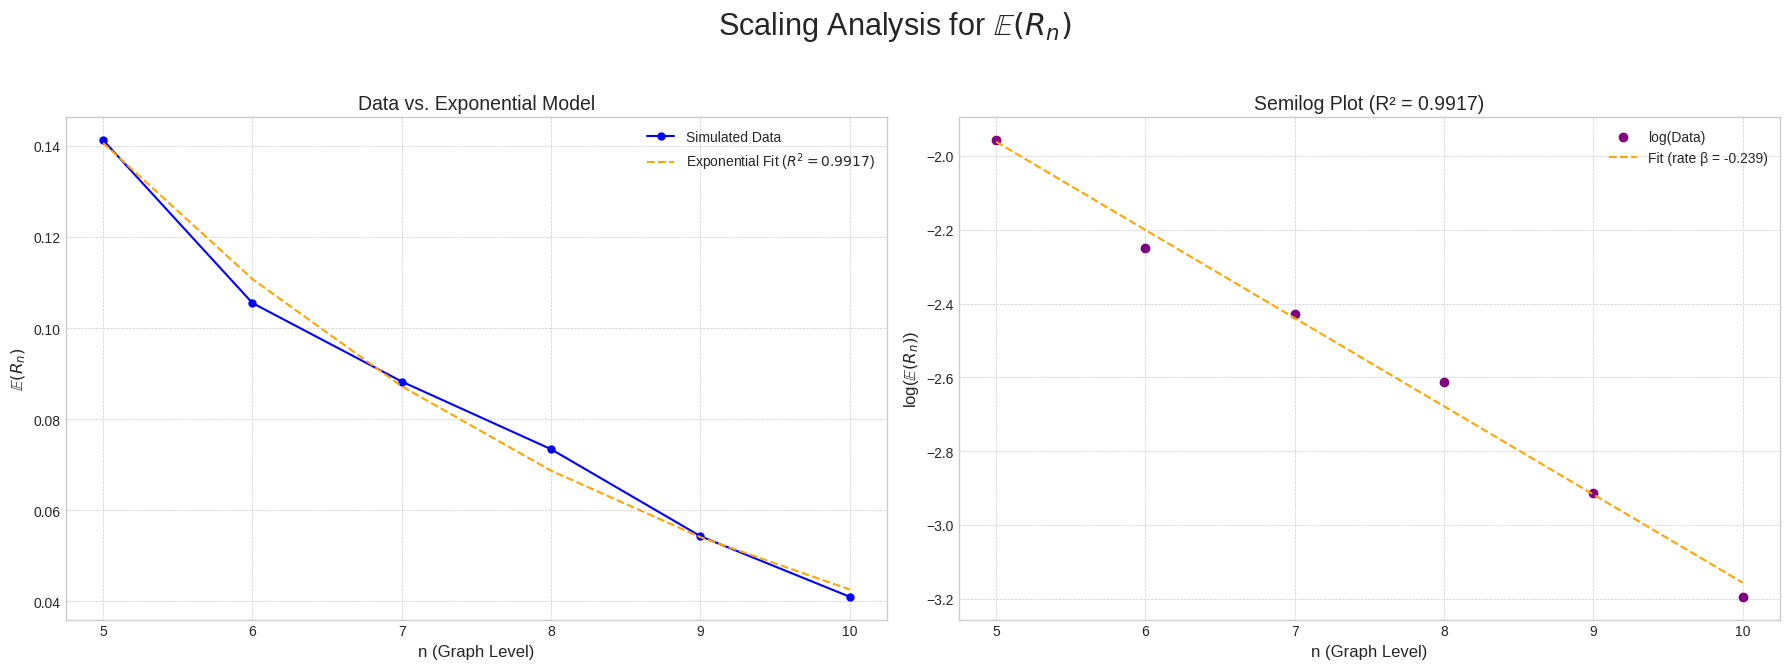

Plot saved to 
Fit parameters for $\mathbb{E}(R_n)$: Decay Rate (β) = -0.2389, R² = 0.9917


In [ ]:
n_values = np.arange(2,n+1)

# filter out first three values for expectation
n_filt = n_values[3:]
mean_filt = mid_mean[3:]

plot_exponential_analysis_pair(n_filt, 1-mean_filt, r'$\mathbb{E}(R_n)$', '')

In [ ]:
n_values = np.arange(2,n+1)

plot_exponential_analysis_pair(n_values, mid_var, r'$\operatorname{Var}(R_n)$', '')


--- Generating analysis plots for VARIANCE ---


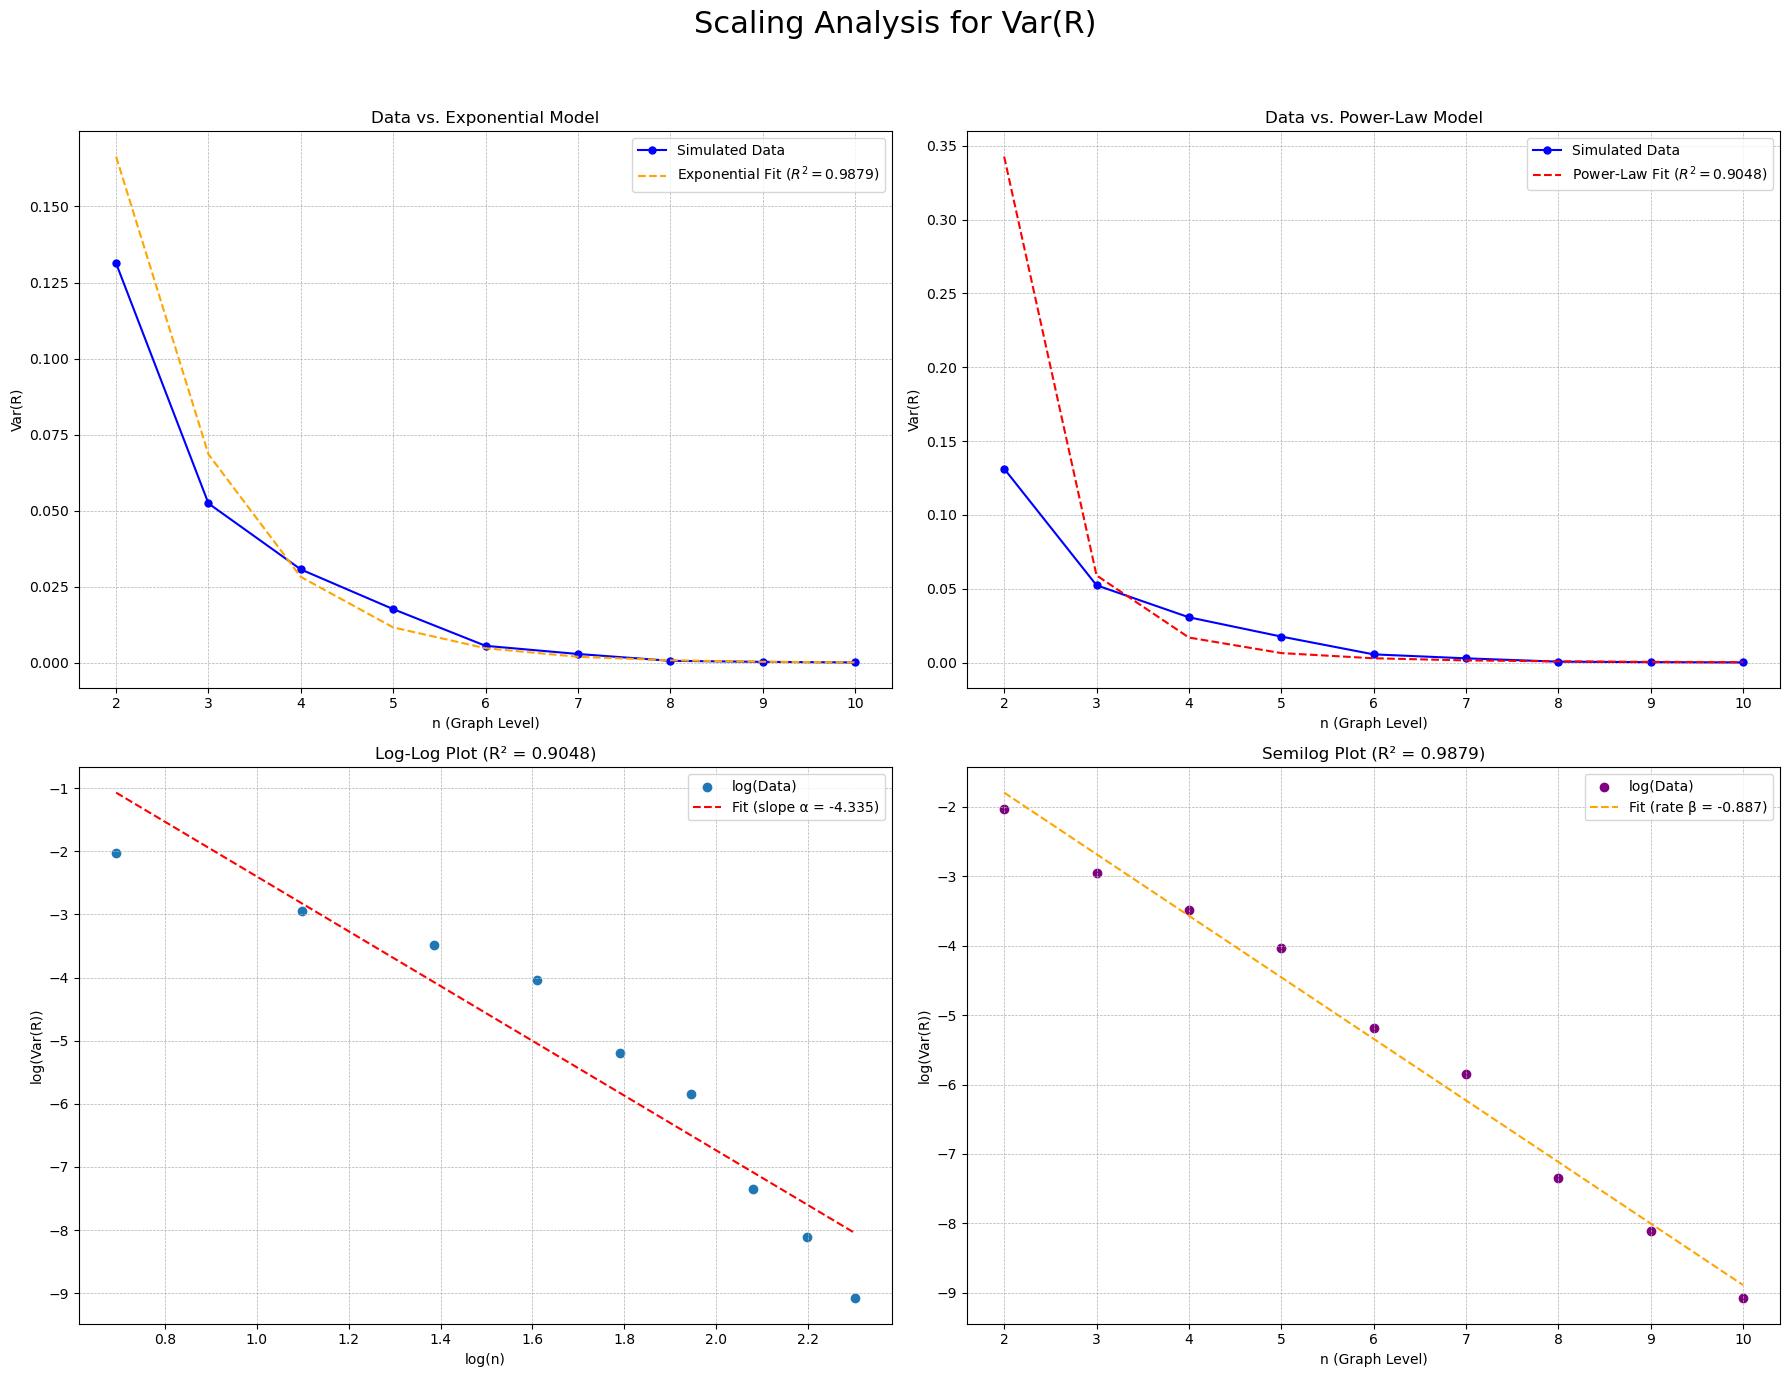

In [ ]:
# --- Analyze the Variance ---
n_values = np.arange(2,n+1)
print("\n--- Generating analysis plots for VARIANCE ---")
analyze_statistic_scaling(
    n_values=n_values,
    statistic_values=mid_var,
    statistic_name="Var(R)"
)


--- Generating analysis plots for MEAN DEVIATION ---


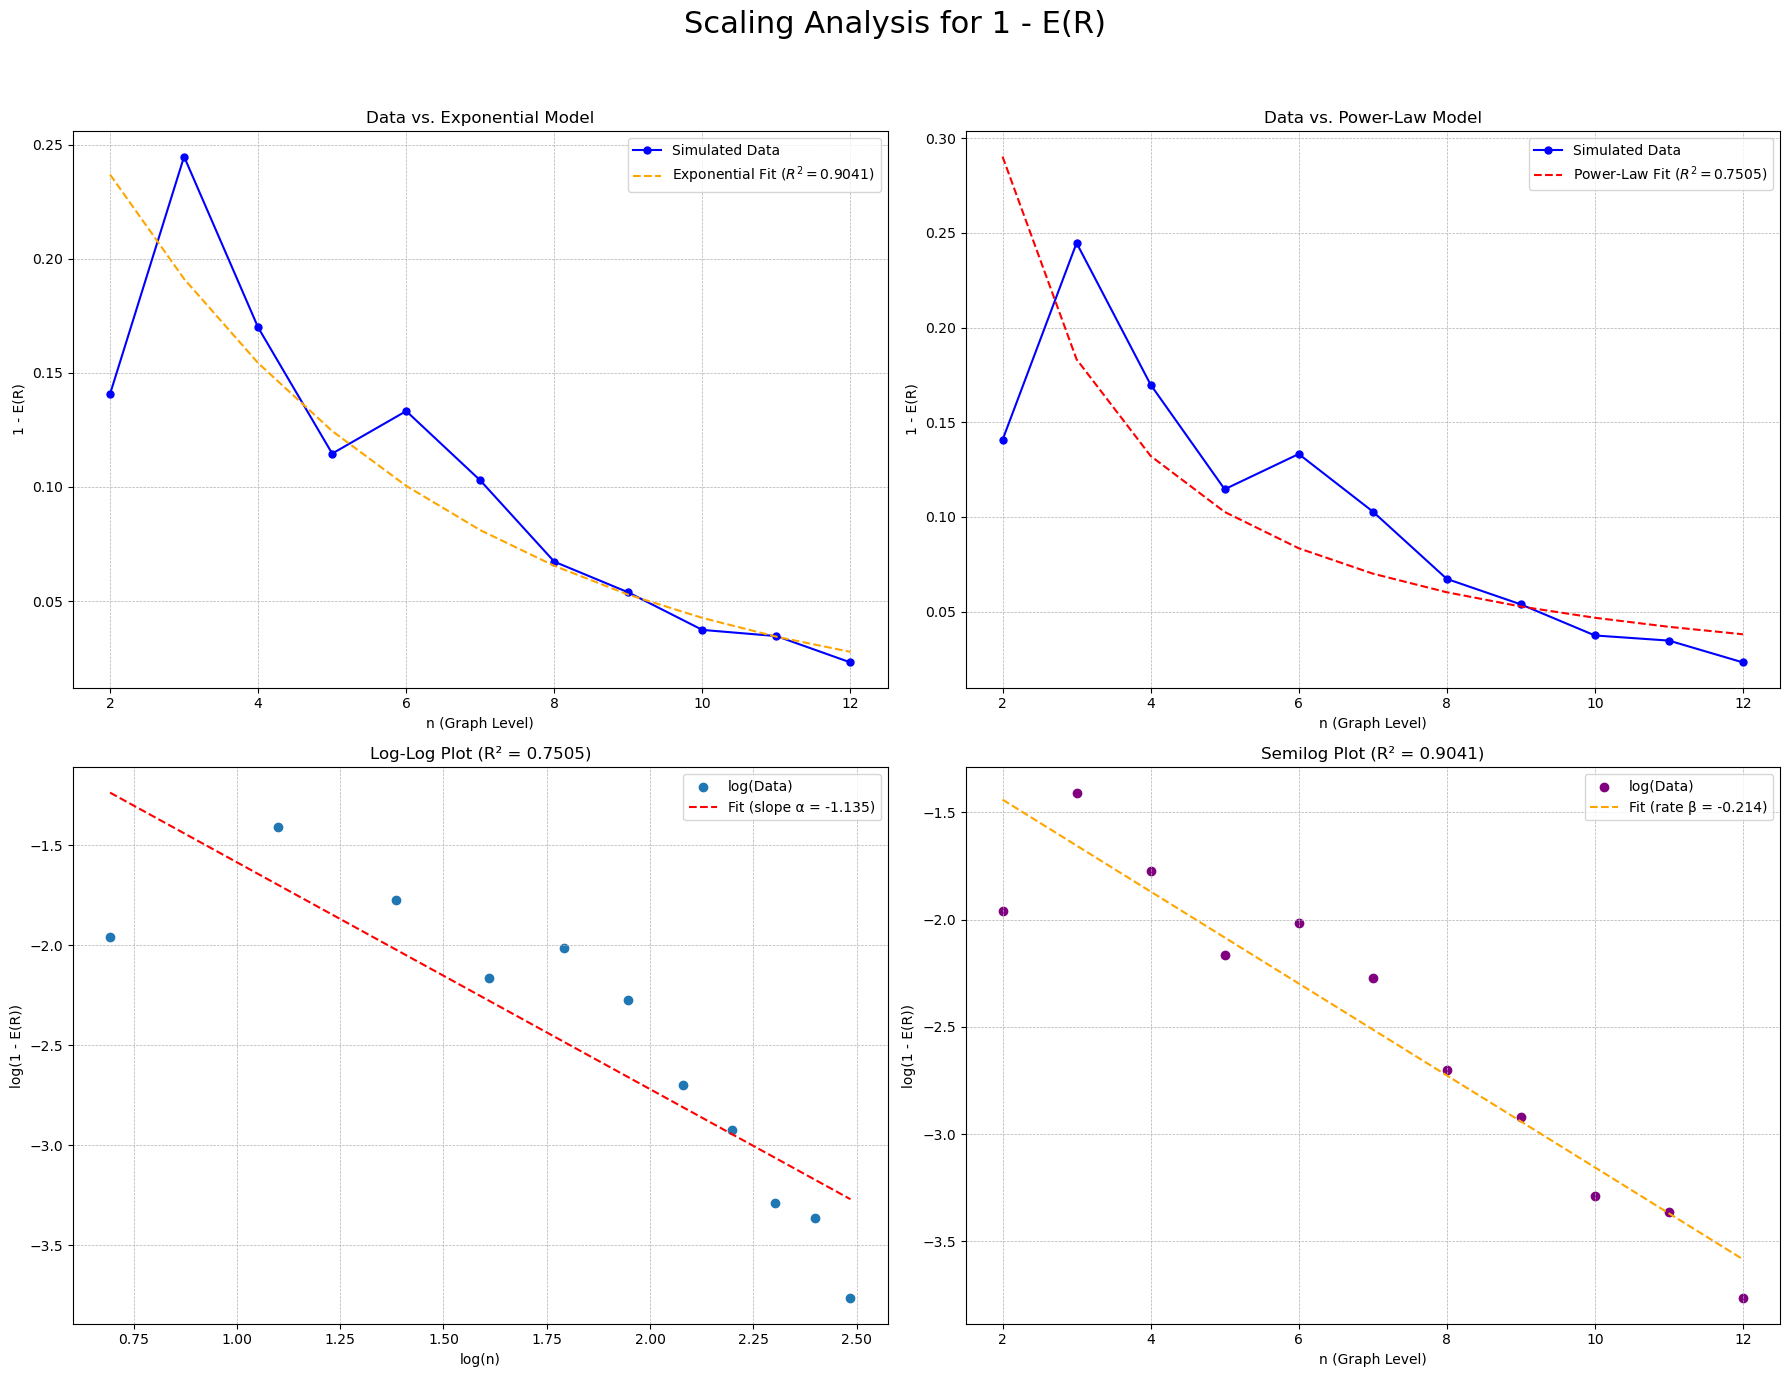

In [ ]:
# --- 3. Analyze the Mean (or its deviation from 1) ---
print("\n--- Generating analysis plots for MEAN DEVIATION ---")
mean_dev = 1 - mid_mean

n_values = np.arange(2, n+1)

# throw out the first three datapoints (too much variation)
filt_dev = mean_dev
filt_nvals = n_values

analyze_statistic_scaling(
    n_values=filt_nvals,
    statistic_values=filt_dev,
    statistic_name="1 - E(R)"
)

# $\mathbb{E}(R_n)$ is slow to converge, so we get rid of CI's (set sample size = 1)

In [ ]:
n = 1

v_a = 'tail_1'
v_b = 'tail_2'

res_list = []
print("--- Starting resistance calculations ---")
# Iterate through graph levels, starting from n=2
for n in range(2, n + 1):
    print(f"Creating graph level n={n}...")
    
    # --- Use the NetworkX graph creation function ---
    G = hanoi_t(n)

    # --- Use the dedicated NetworkX weighting function ---
    # This function modifies the graph G in-place with new random weights.
    add_random_weights(G, n)

    print(f"Computing R_{n}(t_1, t_2)")
    # --- Use the dedicated NetworkX single resistance function ---
    # Compute the resistance for this specific random instance
    R_ab = compute_single_resistance1(G, v_a, v_b)
    res_list.append(R_ab)

# Convert the list of results to a NumPy array for bootstrapping
res_arr_singlePoints = np.array(res_list)

--- Starting resistance calculations ---
Creating graph level n=2...
Computing R_2(t_1, t_2)
Creating graph level n=3...
Computing R_3(t_1, t_2)
Creating graph level n=4...
Computing R_4(t_1, t_2)
Creating graph level n=5...
Computing R_5(t_1, t_2)
Creating graph level n=6...
Computing R_6(t_1, t_2)
Creating graph level n=7...
Computing R_7(t_1, t_2)
Creating graph level n=8...
Computing R_8(t_1, t_2)
Creating graph level n=9...
Computing R_9(t_1, t_2)
Creating graph level n=10...
Computing R_10(t_1, t_2)
Creating graph level n=11...
Computing R_11(t_1, t_2)
Creating graph level n=12...
Computing R_12(t_1, t_2)
Creating graph level n=13...
Computing R_13(t_1, t_2)
Creating graph level n=14...
Computing R_14(t_1, t_2)
Creating graph level n=15...


: 

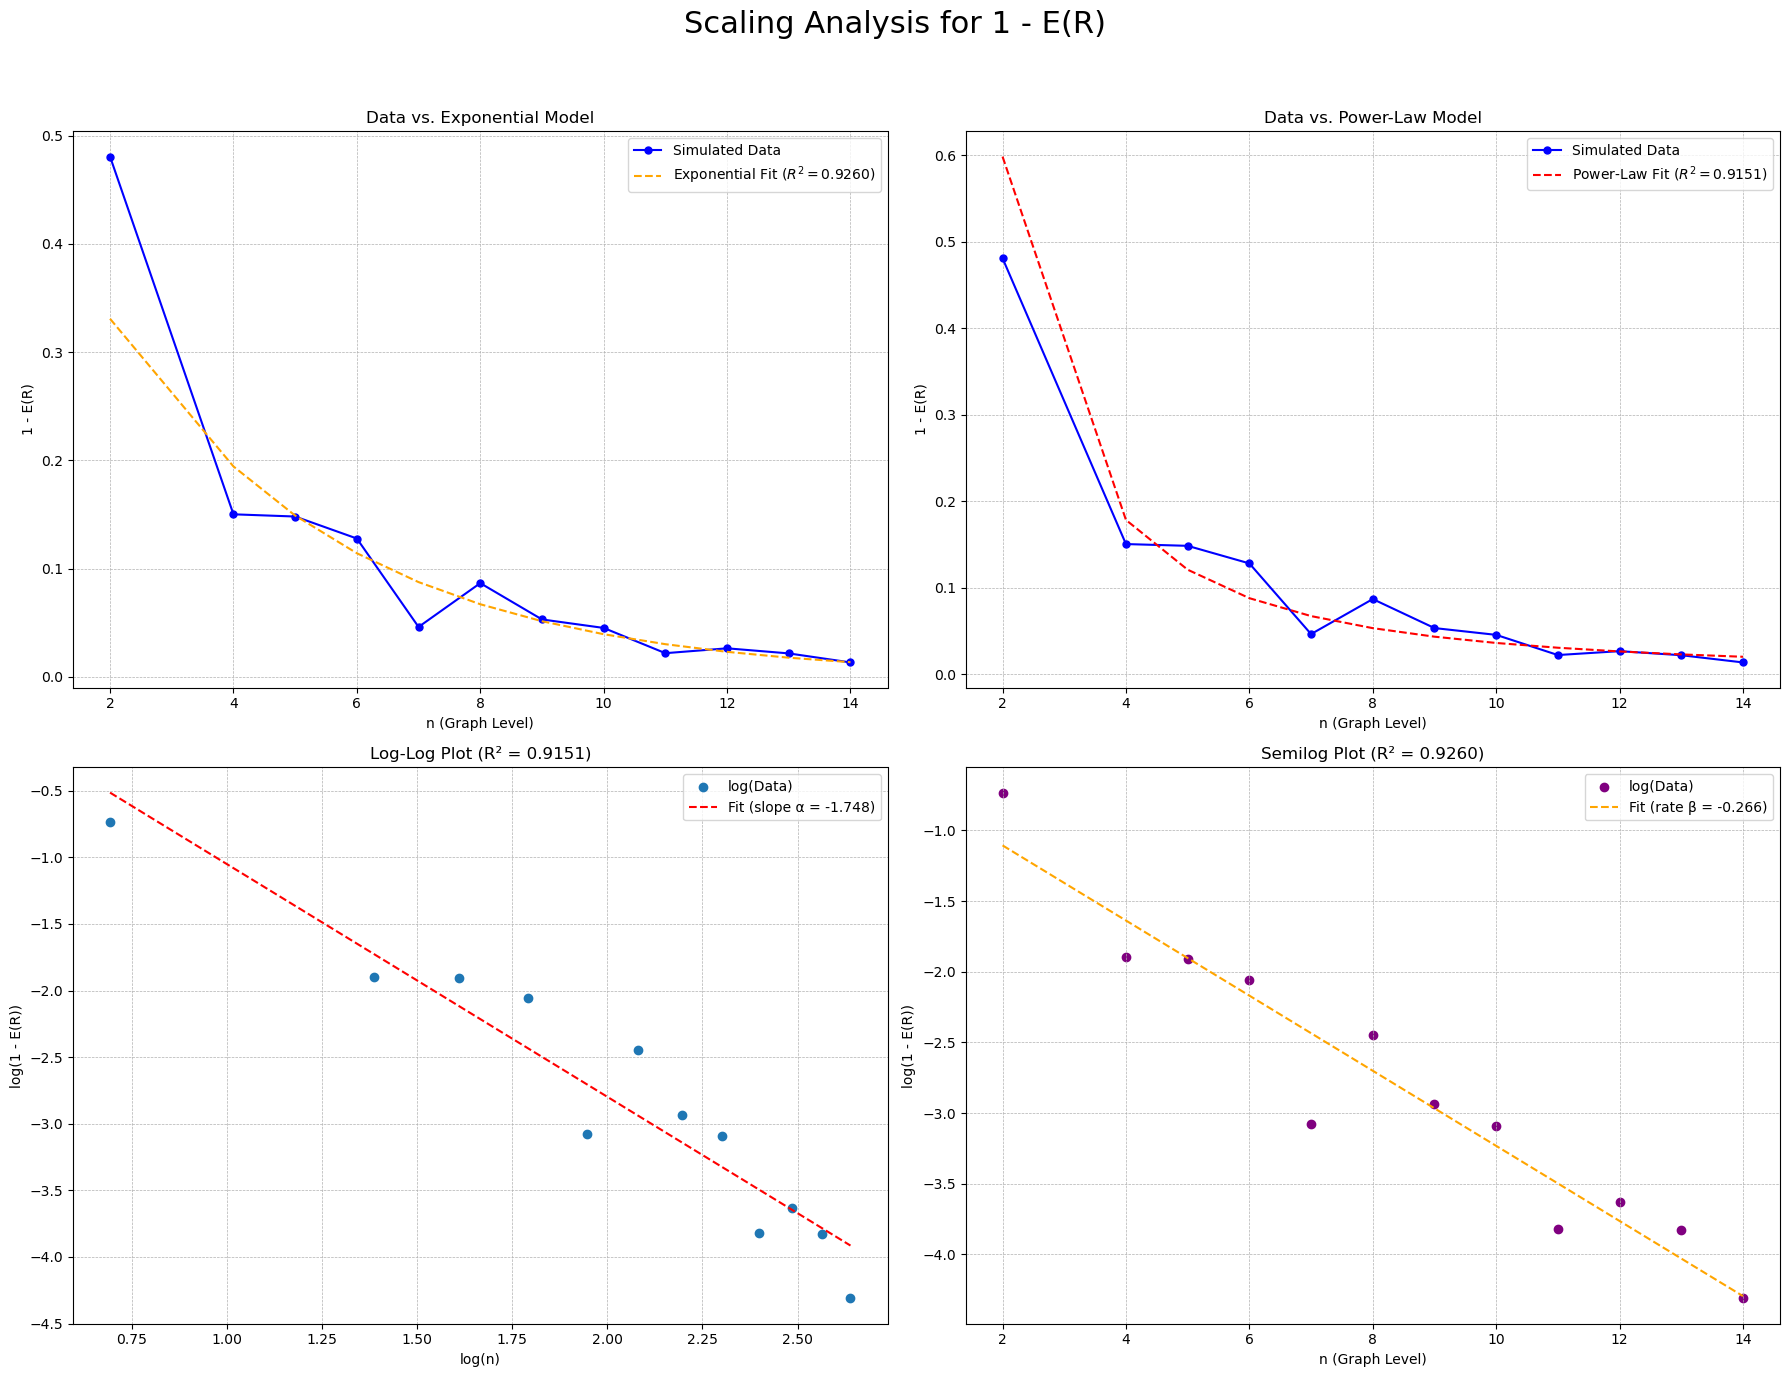

In [ ]:
nvals = np.arange(2, n+1); statVals = 1 - res_arr_singlePoints
# filter to get rid of the first two values
filt_stats = statVals[3:]; filt_nvals = nvals[3:]

analyze_statistic_scaling(
    n_values= nvals,
    statistic_values= statVals,
    statistic_name="1 - E(R)"
)